# Cloud Detection
Dataset: https://www.kaggle.com/datasets/hmendonca/cloud-cover-detection

```shell
kaggle datasets download -d hmendonca/cloud-cover-detection
```

In [1]:
!pip install -q geopandas folium contextily

In [2]:
!pip install numpy==1.24.3 python-box timm segmentation_models_pytorch ttach torch=="1.10.*" pytorch-lightning=="1.6.*" omegaconf

## Auth

In [3]:
%load_ext dotenv
%dotenv ./key.env -o -v

cannot find .env file


## Import 

In [1]:
import os
import warnings
import random
from pprint import pprint
import copy
from typing import List, Tuple
import glob
import json
import csv
# import dataclasses
from joblib import Parallel, delayed

from tqdm import tqdm
import numpy as np
import pandas as pd
from box import Box, from_file
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.optimize import minimize
from sklearn.metrics import jaccard_score
import cv2
import seaborn as sns
import geopandas as gpd
import folium
import contextily as cx

from sklearn.model_selection import StratifiedKFold, KFold
import torch
print(torch.__version__)
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm import create_model
import segmentation_models_pytorch as smp
# from torchmetrics import FBetaScore
import ttach as tta

import pytorch_lightning as pl
print(pl.__version__)
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger, CSVLogger
from pytorch_lightning import LightningDataModule, LightningModule

# import wandb
# wandb.login(key=os.environ["WANDB_API_KEY"])

warnings.filterwarnings("ignore")

torch.autograd.set_detect_anomaly(True)
pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 30

# インライン表示
%matplotlib inline

1.10.2
1.6.5


## Config

In [20]:
from typing import List, Set, Dict, Any

base_channel = 4

class CFG(object):
    # basic
    debug: bool = False
    debug_sample: int = 64
    folds: int  = 4
    seed: int   = 417
    eps: float  = 1e-12
    
    SINGLE_FOLD = True
    
    # data
    PATH_CSV: str  =  f'../data/cloud/train_metadata.csv'
    
    # train
    epoch: int  = 200
    # early_stop_patience:int = int(epoch /10)
    trainer: Dict[str, Any]   = {
        'gpus': 1,
        'accumulate_grad_batches': 1,
        'progress_bar_refresh_rate': 1,
        'stochastic_weight_avg': False,
        'fast_dev_run': False,
        'num_sanity_val_steps': 0,
        'resume_from_checkpoint': None,
        'check_val_every_n_epoch': 2,
        'val_check_interval': 1.0,
        # 'precision' : 16,
        'gradient_clip_val': 15., 
        'gradient_clip_algorithm': "value"
    }
    optimizer: Dict[str, Any] = {
        'name': 'optim.AdamW',
        'params': {
            'lr': 1e-2,
            },
    }
    scheduler: Dict[str, Any] = {
        'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
        'params':{
            'T_0': int(epoch/2),
            'eta_min': 1e-5,
            }
    }
    
    base_channel = base_channel # python bug?
    model: Dict[str, Any] = {
        'timmunet': {
                'encoder_params': {  
                    "encoder": "resnet34",
                    "decoder_filters": [base_channel * (i+1) for i in range(4)],
                    "last_upsample": base_channel,
                },
                'in_chans': 4,
                'out_chans': 1,
        },
        'loss': 'BCEDiceLoss()',
        'threshold': 0.4,
    }
    
    BATCH_SIZE = 16
    train_loader: Dict[str, Any] = {
        'batch_size': BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0,
        'pin_memory': False,
        'drop_last': True,
    }
    val_loader :Dict[str, Any]= {
        'batch_size': BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0,
        'pin_memory': False,
        'drop_last': False
    }
    
    MIXUP_RATIO = 0.5

    
    preprocess: Dict = {
        "input_size": 512,
    }
    
    ENV = 'V100'
    VERSION = 2
    outdir: str = f'../output/cloud/V{VERSION}/'
    
    info = 'C_'
    # model info
    info += f'{model["timmunet"]["encoder_params"]["encoder"]}'
    info += f'BC{base_channel}TH{model["threshold"]}'
    # train info
    info += f'_LR{optimizer["params"]["lr"]}'
    info += f'T0{scheduler["params"]["T_0"]}'
    info += f'MIX{MIXUP_RATIO}B{train_loader["batch_size"]}_fl-tr'
    
    # logging
    project: str = "ChaBuD-ECML-PKDD2023_Cloud"
    runname: str = f"{ENV}"
    group: str   = f'{ENV}_V{VERSION}_{info}'
    notebook: str = '008_cloud_model_uint16.ipynb'
    
    # post info
    augmentation: str =  ''
    fold: int = -1
        

    if debug:
        epoch = 2
        group = 'DEBUG'


# box
cfg = Box({k:v for k, v in dict(vars(CFG)).items() if '__' not in k})
    
# 乱数のシードを設定
seed_everything(cfg.seed)
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)
random.seed(cfg.seed)

os.makedirs(cfg.outdir, exist_ok=True)
    
pprint(cfg)

Global seed set to 417


{'BATCH_SIZE': 16,
 'ENV': 'V100',
 'MIXUP_RATIO': 0.5,
 'PATH_CSV': '../data/cloud/train_metadata.csv',
 'SINGLE_FOLD': True,
 'VERSION': 2,
 'augmentation': '',
 'base_channel': 4,
 'debug': False,
 'debug_sample': 64,
 'epoch': 200,
 'eps': 1e-12,
 'fold': -1,
 'folds': 4,
 'group': 'V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr',
 'info': 'C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr',
 'model': {'loss': 'BCEDiceLoss()',
           'threshold': 0.4,
           'timmunet': {'encoder_params': {'decoder_filters': <BoxList: [4, 8, 12, 16]>,
                                           'encoder': 'resnet34',
                                           'last_upsample': 4},
                        'in_chans': 4,
                        'out_chans': 1}},
 'notebook': '008_cloud_model_uint16.ipynb',
 'optimizer': <Box: {'name': 'optim.AdamW', 'params': {'lr': 0.01}}>,
 'outdir': '../output/cloud/V2/',
 'preprocess': <Box: {'input_size': 512}>,
 'project': 'ChaBuD-ECML-PKDD2023_Cloud',

In [21]:
df = pd.read_csv(cfg.PATH_CSV)
print(df.shape, df.columns)
df.head(4)

(11748, 4) Index(['chip_id', 'location', 'datetime', 'cloudpath'], dtype='object')


chip_id  location              datetime                   cloudpath
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp
1    adwu  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwu
2    adwz  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwz
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp

uint16 (512, 512)
uint8 (512, 512) 1


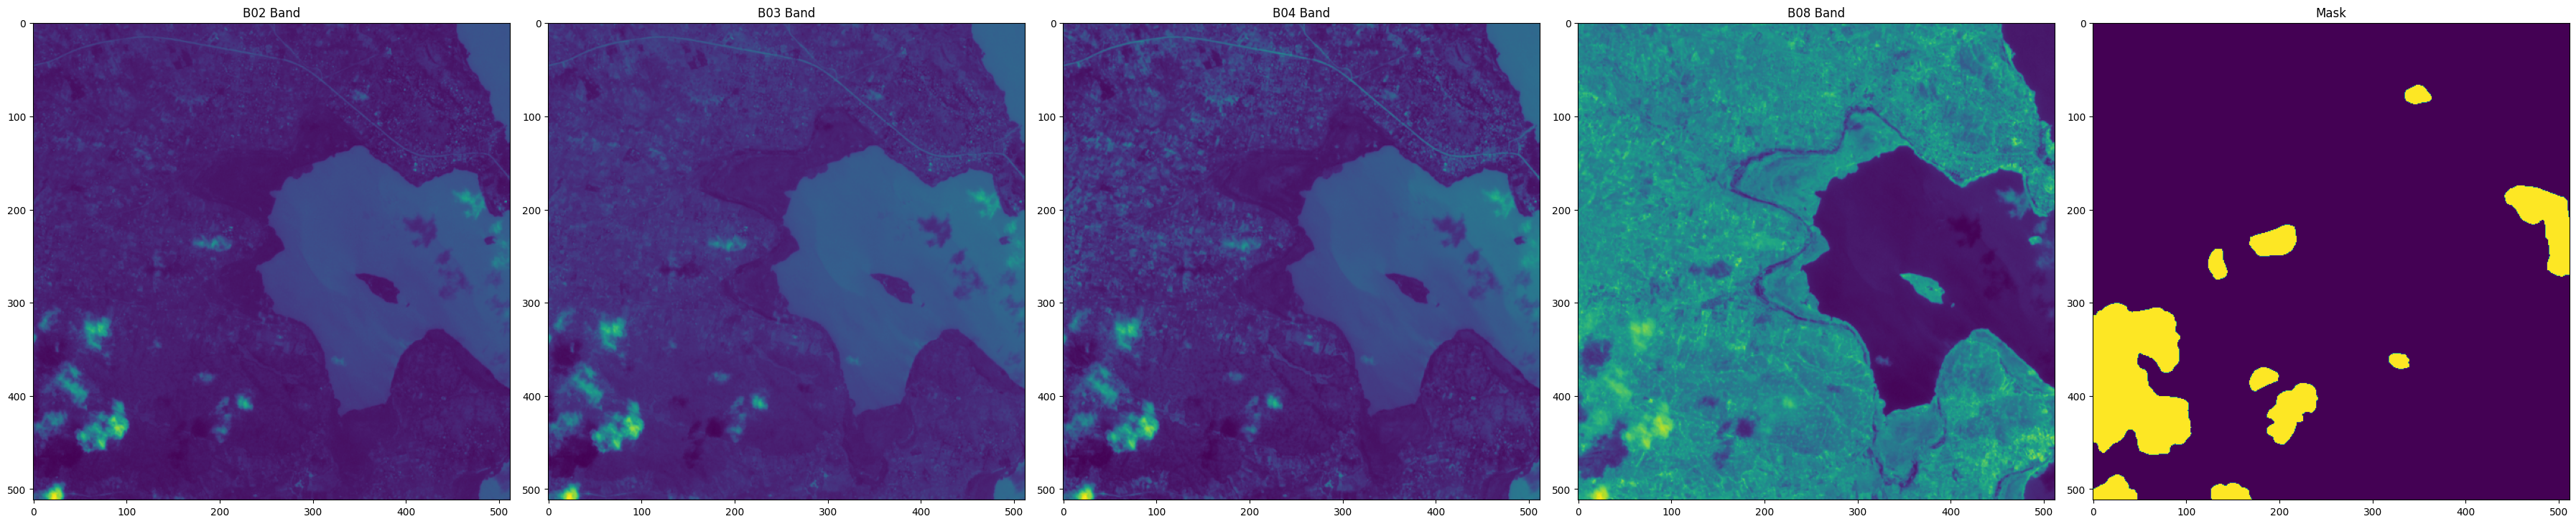

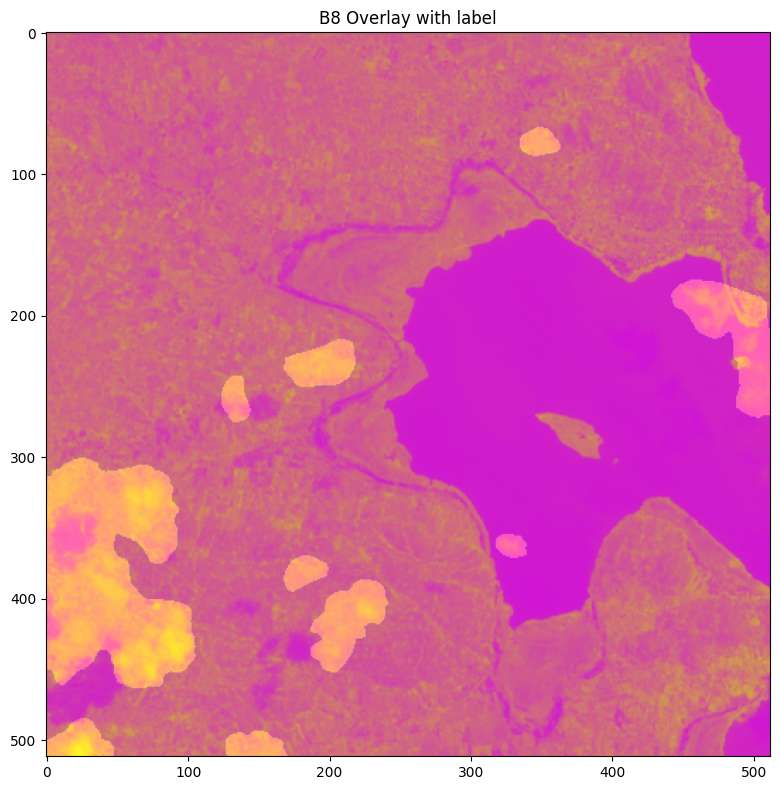

In [22]:
idx = 67

row = df.iloc[idx]
scene = row['chip_id']

plt.figure(figsize=(36, 12))
for i, B in enumerate(['2', '3', '4', '8']):
    img_thum = cv2.imread(f'../data/cloud/data/train_features/{scene}/B0{B}.tif', cv2.IMREAD_ANYDEPTH)
    mask = cv2.imread(f'../data/cloud/data/train_labels/{scene}.tif', cv2.IMREAD_ANYDEPTH) 
    plt.subplot(1, 5, i+1)
    plt.title(f'B0{B} Band')
    plt.imshow(img_thum)
    
print(img_thum.dtype, img_thum.shape)
print(mask.dtype, mask.shape, np.max(mask))

plt.subplot(1, 5, 5)
plt.title('Mask')
plt.imshow(mask * 255)
plt.tight_layout()

plt.savefig(f'{cfg.outdir}/sample_image_pair.png')
plt.show();

plt.figure(figsize=(8, 8))
plt.title('B8 Overlay with label')
plt.imshow(img_thum, alpha=0.9, cmap='spring')
plt.imshow(mask * 255, alpha=0.25)
plt.tight_layout()

plt.savefig(f'{cfg.outdir}/sample_overlay.png')
plt.show();
plt.clf()
plt.close()

## Folds

In [23]:
n_fold = np.zeros(len(df["chip_id"]))
kf = KFold(n_splits=cfg.folds, random_state=cfg.seed, shuffle=True)
for k, (_, val_idx) in enumerate(kf.split(np.array(range(len(df["chip_id"]))))):
    n_fold[val_idx] = k

df["cv"] = n_fold.astype(np.uint8)

In [24]:
df.head()

chip_id  location              datetime                   cloudpath  cv
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp   2
1    adwu  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwu   0
2    adwz  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwz   1
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp   2
4    aeaj  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aeaj   1

## Augmentations

In [25]:
# augmentation
tf_dict = {
    
    'train': A.Compose(
        [

            # A.CoarseDropout(max_holes=4, max_height=4, max_width=4, 
            #                     min_holes=None, min_height=None, min_width=None, 
            #                     fill_value=0.15, mask_fill_value=0.0, always_apply=False, p=0.25),
            # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1,
            #                     border_mode=4, value=None, mask_value=None, always_apply=False,
            #                     approximate=False, same_dxdy=False, p=0.25),
            # A.GridDistortion(num_steps=5, distort_limit=0.4, interpolation=1, 
            #                     border_mode=4, value=None, mask_value=None, always_apply=False, p=0.25),
            # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, interpolation=1, 
            #                     border_mode=4, value=0.01, mask_value=0.0, shift_limit_x=None, shift_limit_y=None, 
            #                     p=0.5),
            # A.OneOf([
            #     A.GaussNoise(var_limit=(1e-4, 8e-2), mean=0., p=0.5),
            #     A.Blur(blur_limit=7, p=0.25),
            #     A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, brightness_by_max=True, p=0.5),
            # ], p=0.9),
            A.Transpose(p=0.25),
            A.Flip(p=0.5),
            # A.Rotate(limit=30, p=0.5),
            A.Resize(cfg.preprocess.input_size, cfg.preprocess.input_size),
            ToTensorV2(),
            ]
        ),
    'val': A.Compose(
        [
            A.Resize(cfg.preprocess.input_size, cfg.preprocess.input_size),
            ToTensorV2(),
        ]
    ),
}

cfg.augmentation = str(tf_dict).replace('\n', '').replace(' ', '')
pprint(cfg.augmentation)

"{'train':Compose([Transpose(always_apply=False,p=0.25),Flip(always_apply=False,p=0.5),Resize(always_apply=False,p=1,height=512,width=512,interpolation=1),ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={}),'val':Compose([Resize(always_apply=False,p=1,height=512,width=512,interpolation=1),ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={})}"


## Dataset

######## Phase val Num sample: 11748


  0%|                                                                                                                                                                 | 0/735 [00:00<?, ?it/s]

torch.Size([16, 512, 512, 4]) torch.Size([16, 512, 512])


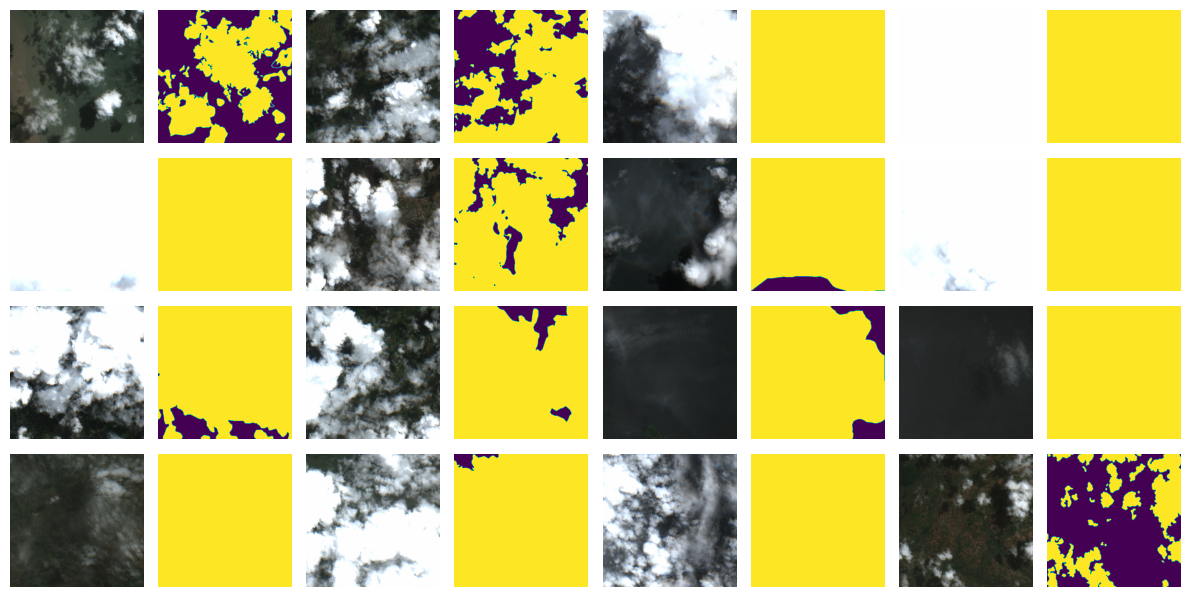

In [26]:
class FireDataset(Dataset):
    def __init__(self,
                 df,
                 phase: str,
                 ):
        self.df = df
        self.phase = phase
        self.transform = tf_dict[self.phase]
        print(f"######## Phase {phase} Num sample:", len(self.df))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        scene = row.chip_id
        
        feature = np.zeros((512, 512, 4), dtype=np.int16)
        for i, B in enumerate(['2', '3', '4', '8']):
            feature[:, :, i] += cv2.imread(f'../data/cloud/data/train_features/{scene}/B0{B}.tif', cv2.IMREAD_ANYDEPTH)
        
        mask = cv2.imread(f'../data/cloud/data/train_labels/{scene}.tif', cv2.IMREAD_ANYDEPTH)
        
        # augmentation
        transformed = self.transform(image=feature, mask=mask)
        
        img, mask = transformed["image"], transformed["mask"]
        img = img.permute(1,2,0)
        
        img, mask = img.float(), mask.float()
        
        return img, mask


def clip_min_max_image(img, clip_min=0, clip_max=7000, norm=255, eps=1e-5, dtype=np.uint8):
    img = img.astype(float).clip(clip_min, clip_max)
    img = norm * (img - clip_min) / (clip_max - clip_min + eps)
    return img.astype(dtype)

class FireModule(LightningDataModule):
    def __init__(
        self,
        df_train,
        df_valid,
        cfg,
    ):
        super().__init__()
        self._cfg = cfg
        self.df_train = df_train
        self.df_valid = df_valid

    def train_dataloader(self):
        dataset = FireDataset(self.df_train, phase='train')
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = FireDataset(self.df_valid, phase='val')
        return DataLoader(dataset, **self._cfg.val_loader)


sample_dataloader = FireModule(df, df, cfg).val_dataloader()
for (imgs, masks) in tqdm(sample_dataloader):
    # is in positive
    print(imgs.shape, masks.shape)
    break

num = 32

os.makedirs(os.path.join(cfg.outdir, 'artifact'), exist_ok=True)

plt.figure(figsize=(12, 12), facecolor='white', tight_layout=True)
for it, (img, mask) in enumerate(zip(imgs[:num],masks[:num])):
    plt.subplot(8, 8, 2*it+1)
    plt.imshow(clip_min_max_image(img[:,:,[2,1,0]].numpy()))
    plt.axis('off')
    plt.subplot(8, 8, 2*it+2)
    plt.imshow(mask.numpy(), vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, 'artifact', f'008_image_mask_visualize_tiles.png'))
plt.show();
plt.clf()
plt.close()

## Model

In [27]:
from utils.models import TimmUnet
# from torchmetrics.functional.classification import binary_fbeta_score
from torchmetrics import FBeta

class FHalfWithLogitsLoss(torch.nn.Module):
    """ Fbeta Extended  with logits Loss """
    def __init__(self, eps=cfg.eps, beta=0.5, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.binary_fbeta_score = binary_fbeta_score = FBeta(num_classes=2, beta=self.beta)

    def forward(self, y_pr, y_gt):
        return 1 - self.binary_fbeta_score(torch.sigmoid(y_pr), y_gt)

class BCEDiceLoss(torch.nn.Module):
    """ Combine Loss """
    def __init__(self, raito=0.5):
        super(BCEDiceLoss, self).__init__()
        assert 0 <= raito <= 1, "loss raito invalid."
        
        self.raito = raito
        self.bce_criterion = torch.nn.BCEWithLogitsLoss()
        self.dice_criterion = FHalfWithLogitsLoss()
        
    def forward(self, y_pr, y_gt):
        loss = self.raito * self.bce_criterion(y_pr, y_gt) + (1 - self.raito) * self.dice_criterion(y_pr, y_gt)
        return loss
    
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam


class FireModel(LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self._criterion = eval(cfg.model.loss)
        
    def __build_model(self):
        self.backbone = TimmUnet(
                in_chans=cfg.model.timmunet.in_chans,
                out_chans=cfg.model.timmunet.out_chans,
                pretrained=True,
                channels_last=False,
                **self.cfg.model.timmunet.encoder_params,
            )

    def forward(self, x):
        feat = self.backbone(x)
        return feat.squeeze(1)

    def training_step(self, batch, batch_idx):
        return self.__share_step(batch, 'train')
        
    def validation_step(self, batch, batch_idx):
        return self.__share_step(batch, 'val')
    
    def __share_step(self, batch, mode):
        images, labels = batch
        labels = labels.float()
        images = images.float()

        if torch.rand(1)[0] < self.cfg.MIXUP_RATIO and mode == 'train':
            mix_images, target_a, target_b, lam = mixup(images, labels, alpha=0.5)
            feat = self.forward(mix_images)
            loss = self._criterion(feat, target_a) * lam + (1 - lam) * self._criterion(feat, target_b)
        
        else:
            feat = self.forward(images)
            # loss
            loss = self._criterion(feat, labels)
        
        logits = torch.sigmoid(feat)
        preds = (logits > cfg.model.threshold).float()
        return_dict = {'loss': loss }
        
        # metrics
        tp = (preds * labels).sum().to(torch.float32)
        tn = ((1. - preds) * (1. - labels)).sum().to(torch.float32)
        fp = (preds * (1. - labels)).sum().to(torch.float32)
        fn = ((1. - preds) * labels).sum().to(torch.float32)
        return_dict[f'TP'] = tp.unsqueeze(dim=0).detach().cpu()
        return_dict[f'TN'] = tn.unsqueeze(dim=0).detach().cpu()
        return_dict[f'FP'] = fp.unsqueeze(dim=0).detach().cpu()
        return_dict[f'FN'] = fn.unsqueeze(dim=0).detach().cpu()
        
        precision = tp / (tp + fp + cfg.eps)
        recall = tp / (tp + fn + cfg.eps)
        f1 = 2 * (precision*recall) / (precision + recall + cfg.eps)
        iou = tp / (tp + fp + fn + cfg.eps)
        
        return_dict[f'Precision'] = precision.unsqueeze(dim=0).detach().cpu()
        return_dict[f'Recall'] = recall.unsqueeze(dim=0).detach().cpu()
        return_dict[f'F1'] = f1.unsqueeze(dim=0).detach().cpu()
        return_dict[f'IoU'] = iou.unsqueeze(dim=0).detach().cpu()
        
        # logging 
        self.log(f'{mode}/iter_TP', tp)
        self.log(f'{mode}/iter_TN', tn)
        self.log(f'{mode}/iter_FP', fp)
        self.log(f'{mode}/iter_FN', fn)
        
        self.log(f'{mode}/iter_Precision', precision)
        self.log(f'{mode}/iter_Recall', recall)
        
        self.log(f'{mode}/iter_F1', f1)
        self.log(f'{mode}/iter_IoU', iou) 
            
        self.log(f'{mode}/iter_loss', loss.detach().cpu())         

        return return_dict
        
    def training_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'train')

    def validation_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'val')    
        
    def __share_epoch_end(self, outputs, mode):
        
        # loss
        losses = []
        for out in outputs:
            losses.append(out['loss'].cpu().detach().numpy())
        losses = np.mean(losses)
        self.log(f'{mode}/epoch_loss', losses)
    
        # metrics
        tps, tns, fps, fns, precisions, recalls, f1s, IoUs = \
            [], [], [], [], [], [], [], []
        for out in outputs:
            # assert False, (out[f'TP'], out[f'TP'].shape)
            for (tp, tn, fp, fn, precision, recall, f1, iou) in zip(out[f'TP'], 
                                        out[f'TN'],
                                        out[f'FP'],
                                        out[f'FN'],
                                        out[f'Precision'],
                                        out[f'Recall'],
                                        out[f'F1'],
                                        out[f'IoU'],):
                
                tps.append(tp.unsqueeze(dim=0))
                tns.append(tn.unsqueeze(dim=0))
                fps.append(fp.unsqueeze(dim=0))
                fns.append(fn.unsqueeze(dim=0))
                
                precisions.append(precision.unsqueeze(dim=0))
                recalls.append(recall.unsqueeze(dim=0))
                f1s.append(f1.unsqueeze(dim=0))
                IoUs.append(iou.unsqueeze(dim=0))
                
        tps = torch.cat(tps, dim=0).squeeze()
        tns = torch.cat(tns, dim=0).squeeze()
        fps = torch.cat(fps, dim=0).squeeze()
        fns = torch.cat(fns, dim=0).squeeze()
        
        precisions = torch.cat(precisions, dim=0).squeeze()
        recalls = torch.cat(recalls, dim=0).squeeze()
        f1s = torch.cat(f1s, dim=0).squeeze()
        IoUs = torch.cat(IoUs, dim=0).squeeze()
        
        
        # logging 
        self.log(f'{mode}/epoch_TP', tps)
        self.log(f'{mode}/epoch_TN', tns)
        self.log(f'{mode}/epoch_FP', fps)
        self.log(f'{mode}/epoch_FN', fns)
        
        self.log(f'{mode}/epoch_Precision', precisions)
        self.log(f'{mode}/epoch_Recall', recalls)
        
        self.log(f'{mode}/epoch_F1', f1s)
        self.log(f'{mode}/epoch_IoU', IoUs)

    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )
        scheduler = eval(self.cfg.scheduler.name)(
            optimizer,
            **self.cfg.scheduler.params
        )
        return [optimizer], [scheduler]

## Inference with Optimizing Threshold

In [28]:
# configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fold = 0

PATH_MODEL_ROOT = f"{cfg.outdir}{cfg.group}/{cfg.runname}_fold{fold}"
PATH_MODEL = f'{PATH_MODEL_ROOT}/iou_fold{fold}.ckpt'
PATH_CFG   = f'{PATH_MODEL_ROOT}/cfg.json'

print(PATH_MODEL, PATH_CFG, '\n')


# restore
inf_cfg = from_file.box_from_file(PATH_CFG)
model = FireModel.load_from_checkpoint(PATH_MODEL, cfg=cfg)
model.eval()
model = model.to(device)

print(f'EVALUATE FOLD: {fold} DEVICE: {device}\n WEIGHT: {PATH_MODEL_ROOT}')

# output

save_preds_dir = f'{PATH_MODEL_ROOT}/inference/visualize/'
os.makedirs(save_preds_dir, exist_ok=True)

../output/cloud/V2/V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr/V100_fold0/iou_fold0.ckpt ../output/cloud/V2/V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr/V100_fold0/cfg.json 

EVALUATE FOLD: 0 DEVICE: cpu
 WEIGHT: ../output/cloud/V2/V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr/V100_fold0


In [29]:
cfg_json_list = glob.glob(os.path.join(cfg.outdir,'**/cfg.json'), recursive=True)
display(cfg_json_list)

['../output/cloud/V2/V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr/V100_fold0/cfg.json',
 '../output/cloud/V2/V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr/V100_fold1/cfg.json',
 '../output/cloud/V2/V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr/V100_fold3/cfg.json',
 '../output/cloud/V2/V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr/V100_fold2/cfg.json']

In [31]:
cfg_json = cfg_json_list[0]

elems = cfg_json.split('/')
outdir = os.path.join(*elems[:4])
group = elems[4]
run_fold = elems[5]
run = run_fold.split('_')[0]
fold = int(run_fold.split('_')[1].replace('fold',''))

cfg.outdir, cfg.group, cfg.run, cfg.fold = outdir, group, run, fold
print(cfg.outdir, cfg.group, cfg.run, cfg.fold)

../output/cloud/V2 V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr V100 0


In [32]:
cfg.debug = False
cfg.SINGLE_FOLD = False

In [33]:
print(cfg.outdir, cfg.group, cfg.runname)
print(cfg.debug, cfg.SINGLE_FOLD, cfg.folds)

../output/cloud/V2 V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr V100
False False 4


In [34]:
# run on MacBook
cfg.val_loader.num_workers = 0
cfg.val_loader

<Box: {'batch_size': 16, 'shuffle': False, 'num_workers': 0, 'pin_memory': False, 'drop_last': False}>

In [38]:
for fold in range(1,cfg.folds):
    
    # fold setting
    PATH_MODEL_ROOT = f"{cfg.outdir}/{cfg.group}/{cfg.runname}_fold{fold}"
    PATH_MODEL = f'{PATH_MODEL_ROOT}/iou_fold{fold}.ckpt'
    PATH_CFG   = f'{PATH_MODEL_ROOT}/cfg.json'
    print(PATH_MODEL, PATH_CFG, '\n')
    

    # output
    save_preds_dir = f'{PATH_MODEL_ROOT}/inference/visualize/'
    os.makedirs(save_preds_dir, exist_ok=True)
    
    # model
    in_cfg = from_file.box_from_file(PATH_CFG)
    model = FireModel.load_from_checkpoint(PATH_MODEL, cfg=cfg)
    model.eval()
    if cfg.debug:
        device = torch.device('cpu')

    model = model.to(device)
    print(f'{device=}')
    
    # TTA
    # model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
    
    val_df = df[df['cv'] == fold].reset_index(drop=True)
    ds_val = FireDataset(val_df, phase='val')
    cfg.val_loader.batch_size = 1
    dl_val = DataLoader(ds_val, **cfg.val_loader)
    
    running_tp = []
    running_fp = []
    running_fn = []
    running_union = []
    running_iou = []
    filenames = []
    precisions = []
    recalls = []
    f1s = []
    ious = []
    positives = []
    count = 0
    
    print(f'#'*60)
    print(f'### Fold: {fold}')
    print(f'#'*60)
    print(f'### Start Inference')
    
    val_df = df[df['cv'] == fold].reset_index(drop=True)

    thresholds = []
    for i, (images, labels) in enumerate(dl_val):
        scene = val_df.iloc[i].chip_id
        
        feature = np.zeros((512, 512, 4), dtype=np.int16)
        for channel, B in enumerate(['2', '3', '4', '8']):
            feature[:, :, channel] += cv2.imread(f'../data/cloud/data/train_features/{scene}/B0{B}.tif', cv2.IMREAD_ANYDEPTH)
        
        mask = cv2.imread(f'../data/cloud/data/train_labels/{scene}.tif', cv2.IMREAD_ANYDEPTH)
        
        # augmentation
        transformed = tf_dict['val'](image=feature, mask=mask)
        
        img, mask = transformed["image"], transformed["mask"]
        # img = img.permute(2, 0, 1)
        
        images, labels = img.float().unsqueeze(0), mask.float().unsqueeze(0)
        print("###### Evaluating: ", f'{i}/{len(ds_val)}', os.path.basename(scene))
        
        # cuda
        images = images.to(device)
        labels = labels.to(device)
        # print(images.size(), images.type(), images.max(), images.min())

        # inference
        with torch.no_grad():
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs) # B, H, W
        
        outputs = outputs.cpu().numpy()
        images = images.cpu().numpy()
        
        # Allocate False Color
        preimg = images[0, :3, :, :]# B, C:4, H, W
        fire = labels[0].cpu().numpy() # B, H, W
        outputs = outputs[0, :, :] # H, W
        
        # min max normalization for png images
        preimg_ = (preimg - preimg.min()) / (preimg.max() - preimg.min())
        fire_ = (fire - fire.min()) / (fire.max() - fire.min())
        output_ = (outputs - outputs.min()) / (outputs.max() - outputs.min())
            
        # save image
        preimg_ = (preimg_ * 255).astype(np.uint8).transpose(1, 2, 0)
        fire_ = (fire_ * 255).astype(np.uint8)
        output_ = (output_ * 255).astype(np.uint8)
        
        # save image
        cv2.imwrite(f'{save_preds_dir}/{os.path.basename(scene)}_TrueColor.png', preimg_)
        cv2.imwrite(f'{save_preds_dir}/{os.path.basename(scene)}_cloud.png', fire_)
        cv2.imwrite(f'{save_preds_dir}/{os.path.basename(scene)}_output.png', output_)
        del preimg_, fire_, output_
            
        # metrics
        gt = fire.copy()
        prediction = outputs.copy()

        tp = np.rint(prediction * gt)
        fp = np.rint(prediction - tp)
        fn = np.rint(gt - tp)
        union = np.rint(np.sum(prediction + gt - tp))

        iou = np.sum(tp) / np.sum((prediction + gt - tp + 0.00001))
        tp = np.sum(tp).astype(int)
        fp = np.sum(fp).astype(int)
        fn = np.sum(fn).astype(int)
        
        precision = tp / (tp + fp + 0.00001)
        recall = tp / (tp + fn + 0.00001)
        f1 = 2 * precision * recall / (precision + recall + 0.00001)
        
        running_tp.append(tp)
        running_fp.append(fp)
        running_fn.append(fn)
        running_union.append(union)
        running_iou.append(iou)
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        ious.append(iou)
        
        if np.max(fire) < 0.5:
            positives.append(False)
        else:
            positives.append(True)
        
        count += 1
        

        # optimize threshold
        def _opt(x):
            return -jaccard_score(fire, outputs >= x, average='micro') 
        
        result = minimize(_opt, x0=np.array([0.45]), method='Powell', tol=1e-2)
        best_th = result['x'].item()
        thresholds.append(best_th)   
        # early exit
        if cfg.debug and i > 2:
            break
        
    running_tp = np.array(running_tp)
    running_fp = np.array(running_fp)
    running_fn = np.array(running_fn)
    running_union = np.array(running_union)
    running_iou = np.array(running_iou)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    ious = np.array(ious)
    
    if cfg.debug:
        val_df = val_df.loc[:len(ious)-1,:]

    
    # foldout metrics
    print()
    val_df[f'tp'] = running_tp
    val_df[f'fp'] = running_fp
    val_df[f'fn'] = running_fn
    precision = running_tp / (running_tp + running_fp + 0.00001)
    recall = running_tp / (running_tp + running_fn + 0.00001)
    f1 = 2 * (precision * recall) / (precision + recall + 0.00001)
    iou = running_tp / (running_union + 0.00001)
    print("  precision: ", precision.mean())
    val_df[f'precision'] = precision
    print("  recall: ", recall.mean())
    val_df[f'recall'] = recall
    print("  f1: ", f1.mean())
    val_df[f'f1'] = f1
    print("  iou: ", iou.mean())
    val_df[f'iou'] = iou
    
    val_df[f'threshold'] = thresholds
    print(" threshold: ", np.mean(thresholds))
    val_df[f'positive'] = positives

    val_df.to_csv(f'{PATH_MODEL_ROOT}/inference/oof_fold{fold}_threshold{cfg.model.threshold}.csv', index=False, header=True)
    
    if cfg.SINGLE_FOLD:
        break
    

../output/cloud/V2/V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr/V100_fold1/iou_fold1.ckpt ../output/cloud/V2/V100_V2_C_resnet34BC4TH0.4_LR0.01T0100MIX0.5B16_fl-tr/V100_fold1/cfg.json 

device=device(type='cpu')
######## Phase val Num sample: 2937
############################################################
### Fold: 1
############################################################
### Start Inference
###### Evaluating:  0/2937 adwz
###### Evaluating:  1/2937 aeaj
###### Evaluating:  2/2937 aeey
###### Evaluating:  3/2937 aehu
###### Evaluating:  4/2937 aejg
###### Evaluating:  5/2937 aelg
###### Evaluating:  6/2937 aemb
###### Evaluating:  7/2937 aesb
###### Evaluating:  8/2937 aesz
###### Evaluating:  9/2937 aewm
###### Evaluating:  10/2937 aeze
###### Evaluating:  11/2937 afbr
###### Evaluating:  12/2937 afef
###### Evaluating:  13/2937 afel
###### Evaluating:  14/2937 afgu
###### Evaluating:  15/2937 afqi
###### Evaluating:  16/2937 aftu
###### Evaluating:  17/2937 afuh
######

## Analysis

threshold mean: -0.45735577801462485
thresh hold mean: 0.42916218115361954


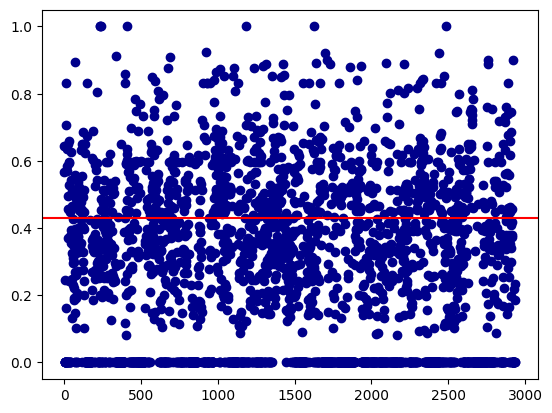

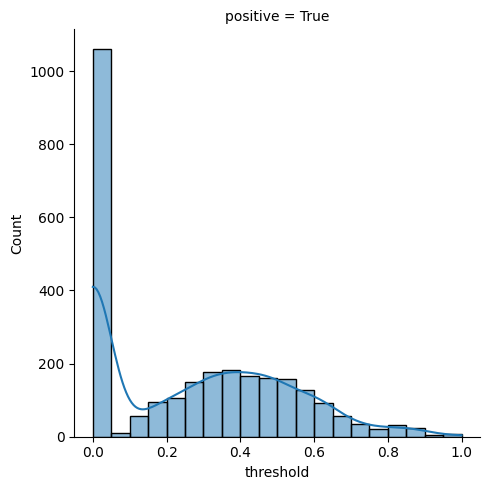

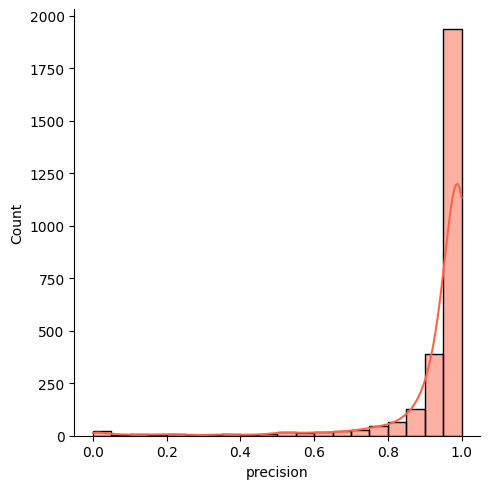

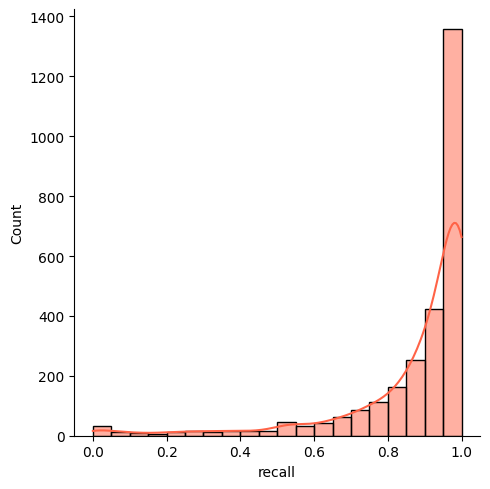

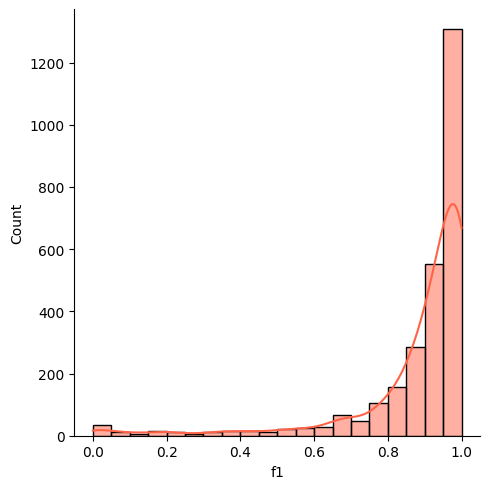

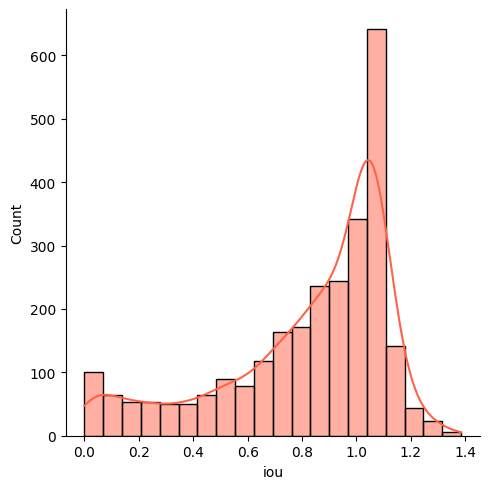

In [39]:
col = 'threshold'
plt.scatter(x=val_df.index, y=val_df[col], c='DarkBlue')
mean_th = val_df[col].values.mean()
print(f'threshold mean: {mean_th}')

plt.axhline(y=mean_th, xmin=0, xmax=len(val_df))
plt.savefig(f'{PATH_MODEL_ROOT}/inference/threshold_all_fold{fold}.png')
# plt.show();
plt.clf()
plt.close()

val_df[col] = np.clip(val_df[col].values, a_min=0, a_max=1)

# normal values
val_pos_df = val_df[val_df['positive'] == True]
bet_th = val_pos_df[(val_pos_df[col] < 1.0) & (val_pos_df[col] > 0.)]
mean_th = bet_th[col].values.mean()
print(f'thresh hold mean: {mean_th}')

plt.scatter(x=val_pos_df.index, y=np.clip(val_pos_df[col].values, a_min=0, a_max=1), c='DarkBlue')
plt.axhline(y=mean_th, xmin=0, xmax=len(bet_th), color='r')
plt.savefig(f'{PATH_MODEL_ROOT}/inference/threshold_better_fold{fold}.png')
plt.show();

sns.displot(data=val_pos_df, x="threshold", col="positive", kde=True, bins=20)

for col in ['precision', 'recall', 'f1', 'iou']:
    for col_v in ['precision', 'recall', 'f1', 'iou']:
        if col == col_v:
            continue
        sns.displot(data=val_pos_df, x=col, y=col_v, kind='kde', rug=True)
        
        plt.savefig(f'{PATH_MODEL_ROOT}/inference/dist{col}-{col_v}_fold{fold}_2d.png')
        # plt.show();
        plt.clf()
        plt.close()
    sns.displot(data=val_pos_df, x=col, kde=True, bins=20, color='tomato')
    plt.savefig(f'{PATH_MODEL_ROOT}/inference/dist_{col}_fold{fold}.png')
    plt.show();
    plt.clf()
    plt.close()

IoU Psitive Only 0.8172142753786135
IoU include Negative and Zero 0.7601734424018971
IoU include Negative and One 0.8333773920103411


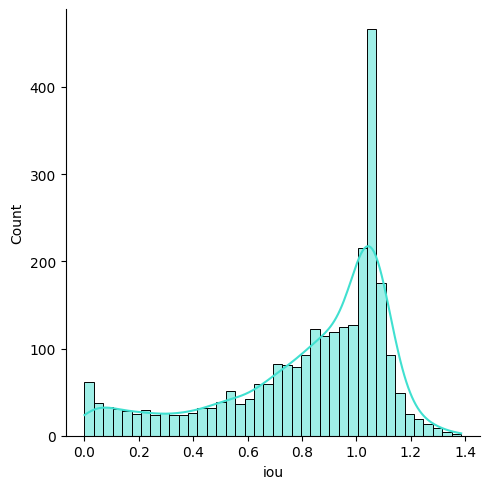

In [40]:
val_pos_df = val_df[val_df['positive'] == True]

# Only positive data
iou_positive_zero_score = val_pos_df['iou'].values.mean()
print('IoU Psitive Only', iou_positive_zero_score)

# Negative data values -> 0
iou_positive_zero_score = val_df['iou'].values.mean()
print('IoU include Negative and Zero', iou_positive_zero_score)

# Negative data values -> 1
val_df.loc[val_df['iou'] == 0.0, 'iou'] = 1
val_df['iou'].values.mean()
iou_positive_one_score = val_df['iou'].values.mean()
print('IoU include Negative and One', iou_positive_one_score)

sns.displot(data=val_pos_df, x='iou', kde=True, bins=40, color='turquoise')
plt.savefig(f'{PATH_MODEL_ROOT}/inference/dist_{col}.png')
plt.show();
plt.clf()
plt.close()

In [41]:
TOP_N = 16
df_error = val_pos_df.sort_values(by=['iou','chip_id'], ascending=[True, True,],)
df_error_top = df_error[:TOP_N]
df_error_top[['iou', 'chip_id']]

iou chip_id
227   0.000000    bvza
231   0.000000    bwou
232   0.000000    bxer
237   0.000000    bxog
410   0.000000    csxg
589   0.000000    dwxo
1156  0.000000    kzwv
1181  0.000000    lckd
1627  0.000000    ohka
2483  0.000000    wvdh
1097  0.000103    khms
382   0.000202    crfn
2461  0.000267    wtnk
425   0.000312    cutq
422   0.000671    cucs
2834  0.000782    yvwr

######## Phase val Num sample: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]

torch.Size([16, 512, 512, 4]) torch.Size([16, 512, 512])


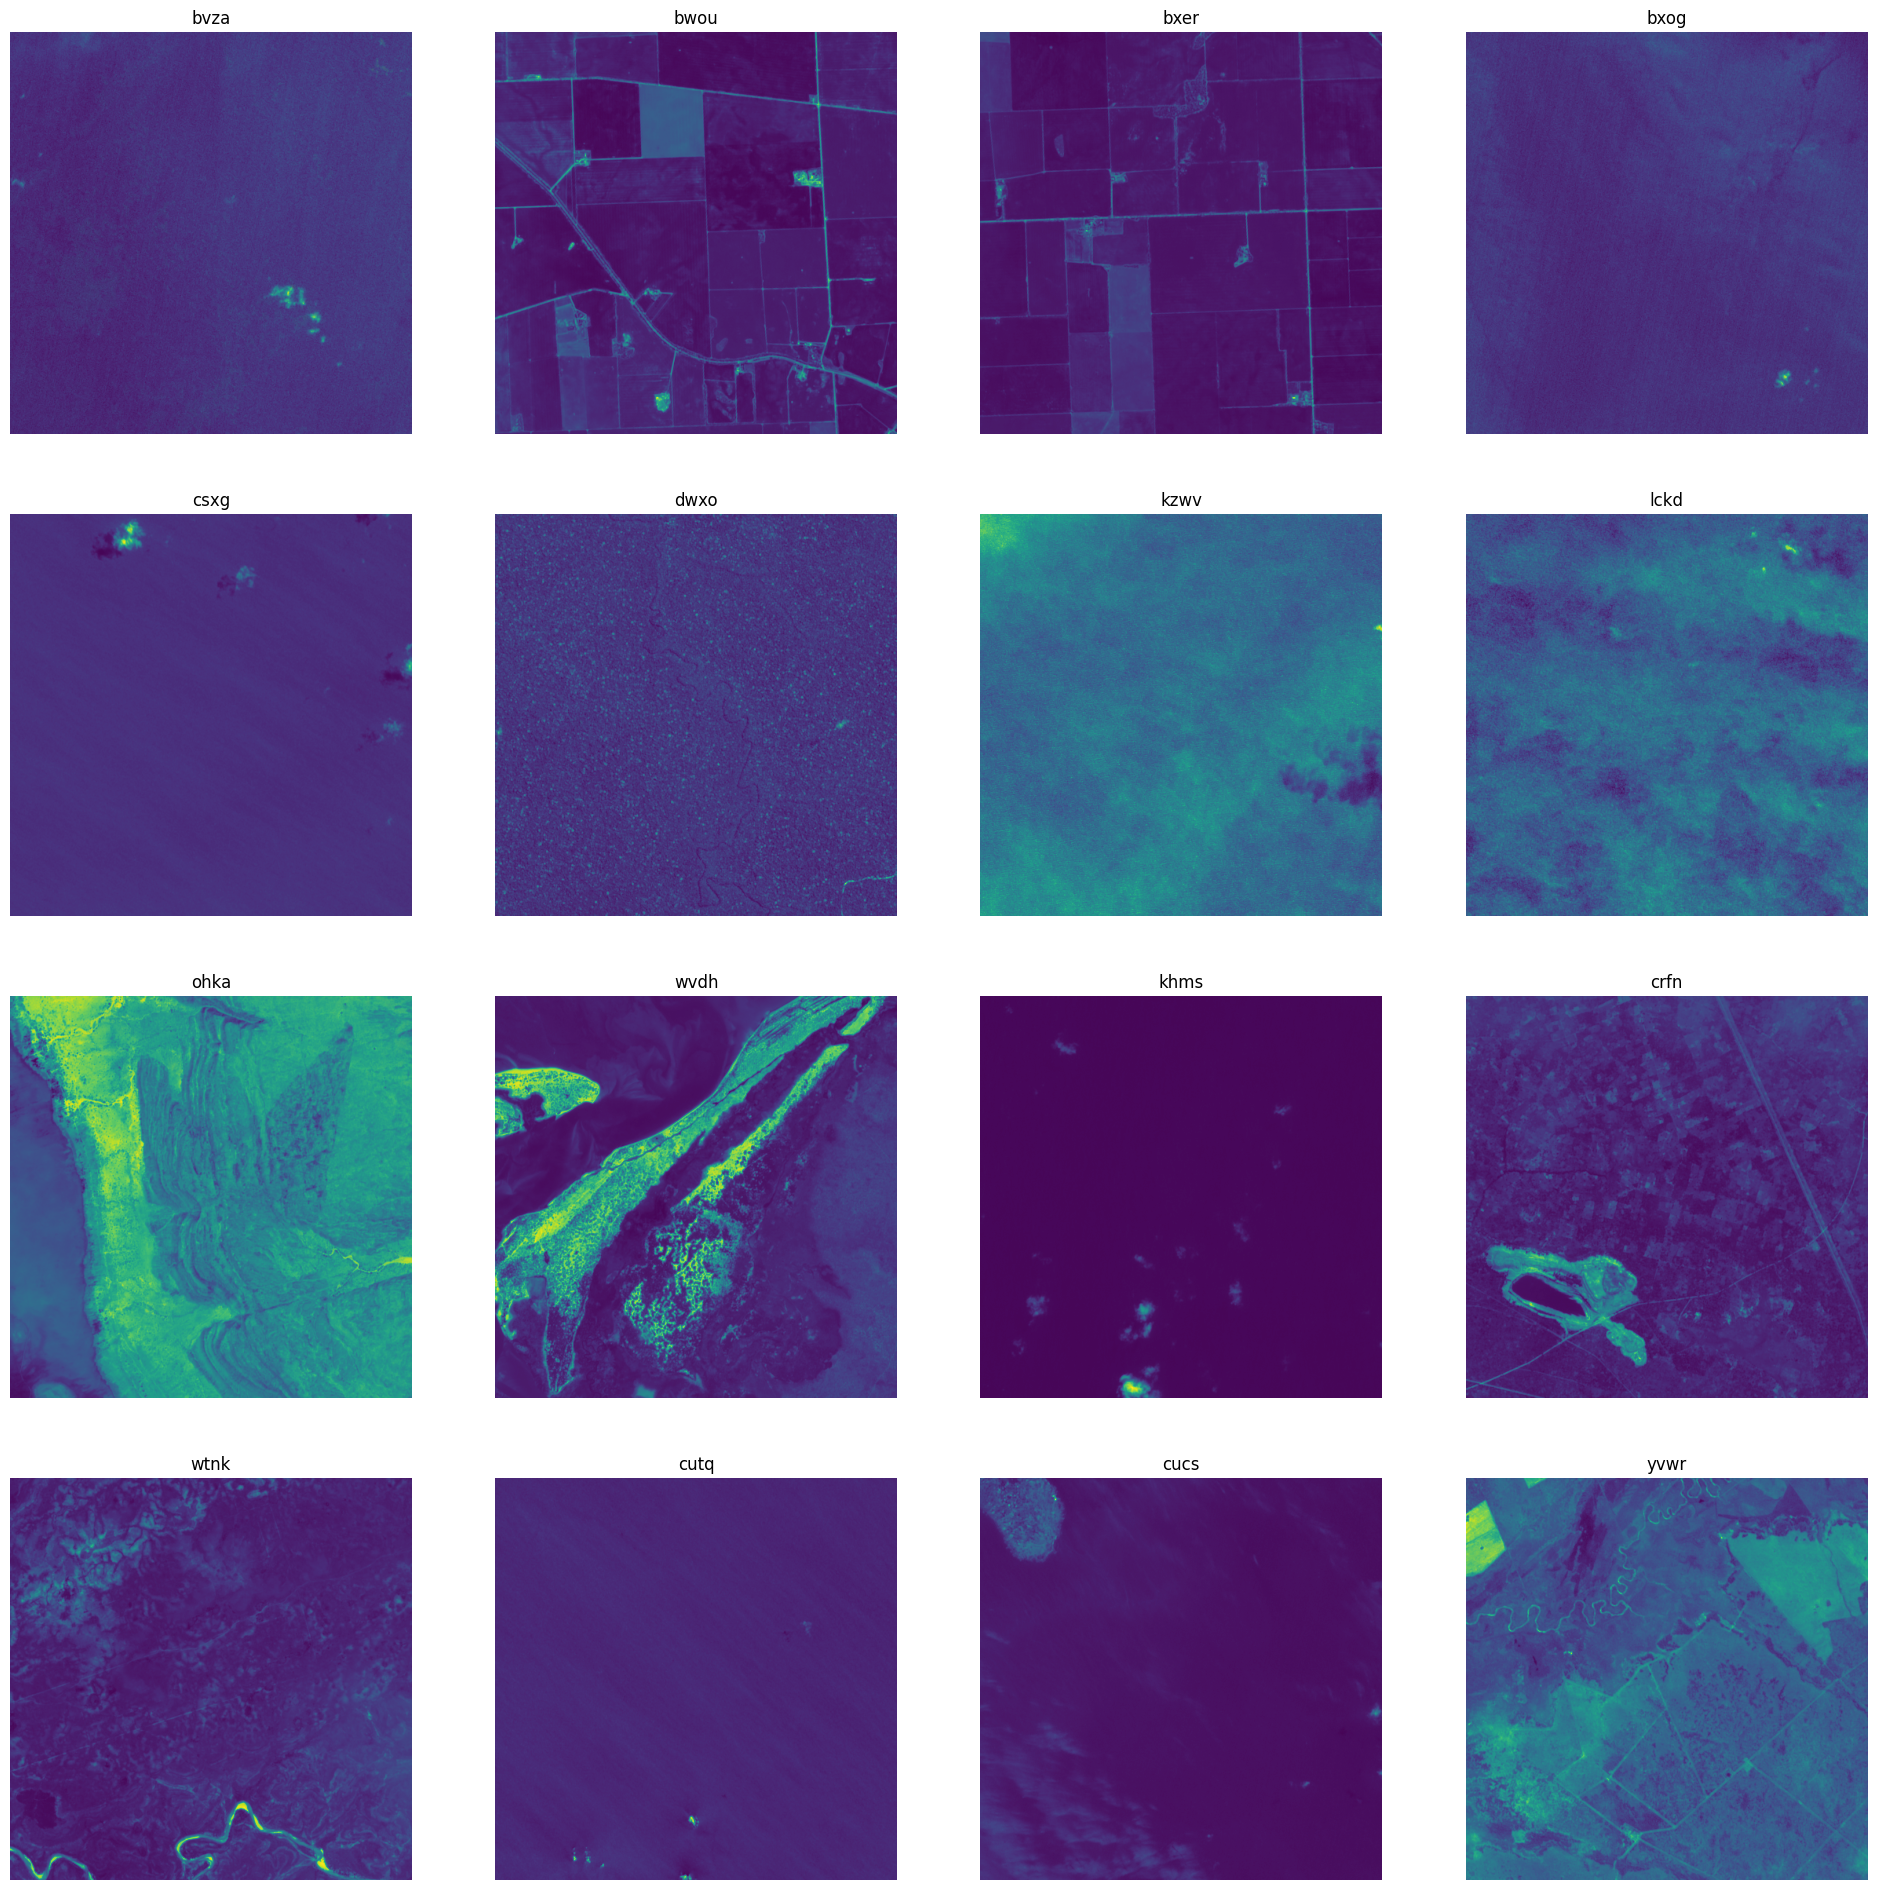

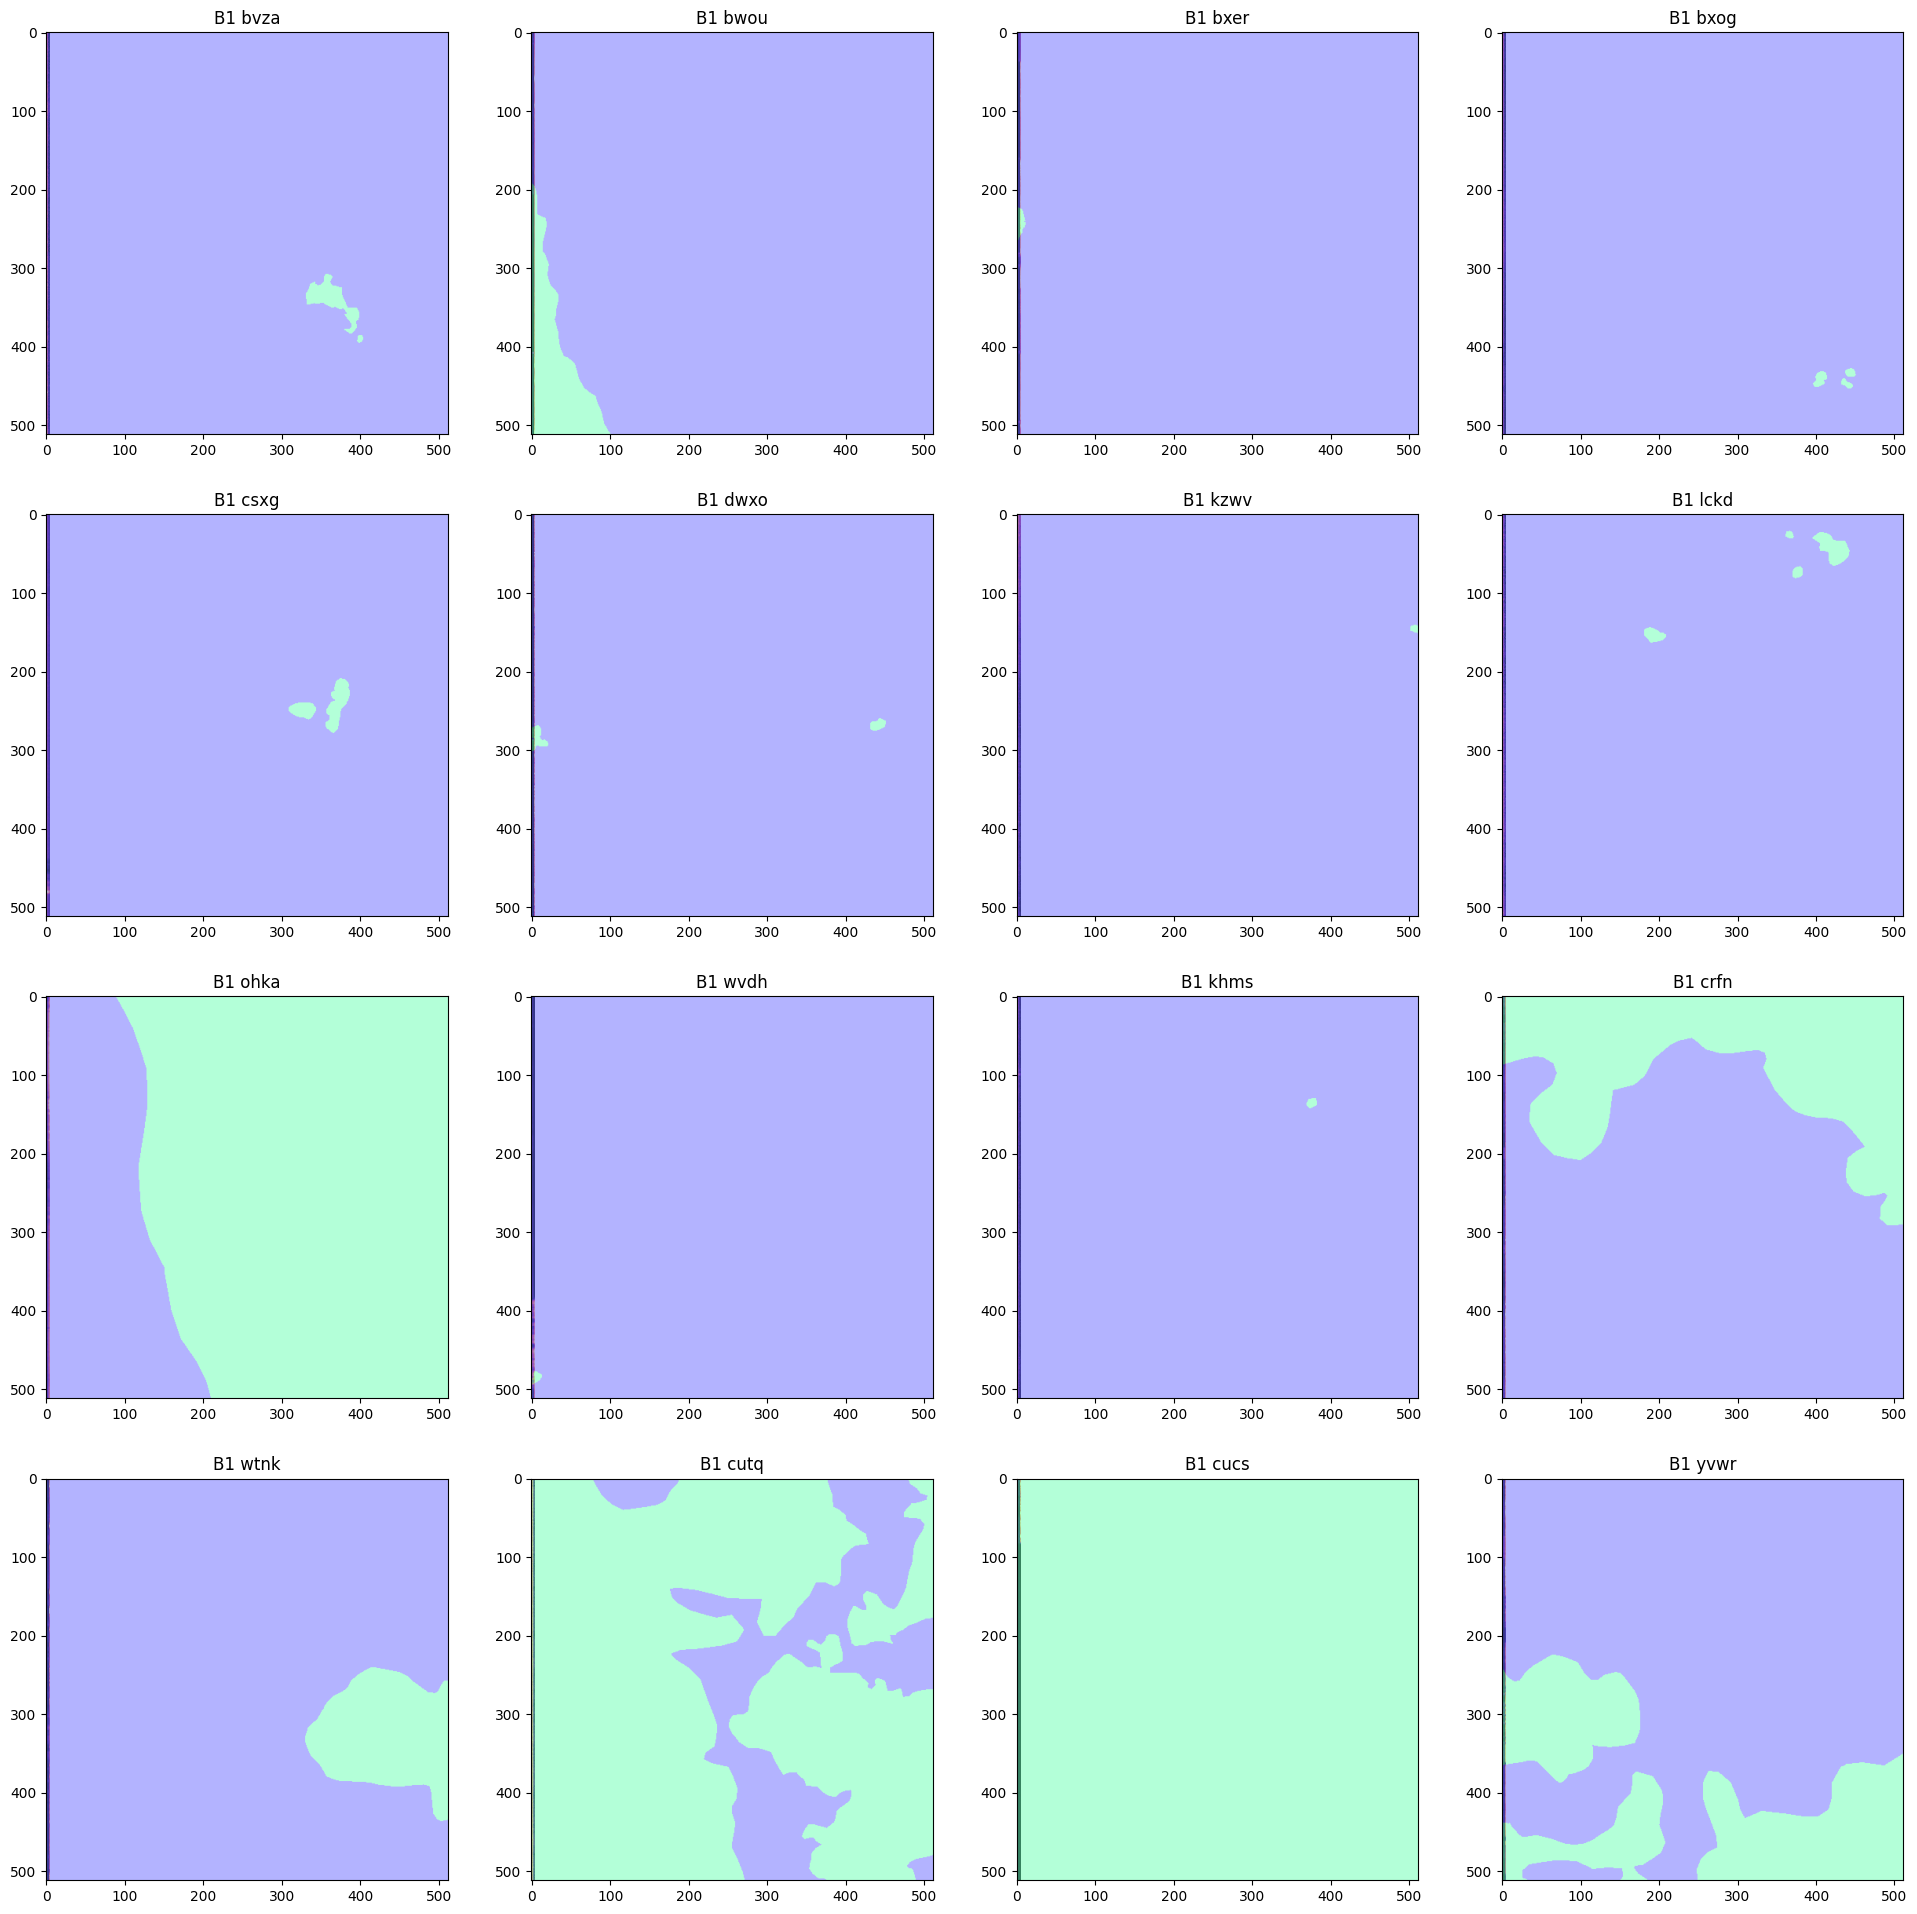

In [42]:
cfg.val_loader.batch_size = TOP_N
sample_dataloader = FireModule(df_error_top, df_error_top, cfg).val_dataloader()
for (imgs, masks) in tqdm(sample_dataloader):
    # is in positive
    print(imgs.shape, masks.shape)

os.makedirs(os.path.join(cfg.outdir, 'artifact'), exist_ok=True)

plt.figure(figsize=(24, 24), facecolor='white')
for it, img in enumerate(imgs):
    plt.subplot(4, 4, it+1)
    uuid = df_error_top.iloc[it]['chip_id']
    plt.title(uuid)
    plt.imshow(img[:,:,0].numpy(), alpha=0.75)
    plt.imshow(img[:,:,1].numpy(), alpha=0.75)
    plt.imshow(img[:,:,2].numpy(), alpha=0.75)
    
    plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, 'artifact', f'008_post_image_visualize_tiles_error.png'))
plt.show();
plt.clf()
plt.close()

plt.figure(figsize=(24, 24), facecolor='white')
for it, mask in enumerate(masks):
    plt.subplot(4, 4, it+1)
    uuid = df_error_top.iloc[it]['chip_id']
    plt.title(uuid)
    plt.imshow(mask.numpy())
plt.savefig(os.path.join(cfg.outdir, 'artifact', f'008_mask_visualize_tiles_error.png'))
# plt.show();
plt.clf()
plt.close()

for idx_band in range(4):
    
    plt.figure(figsize=(24, 24), facecolor='white')
    for it, (img, mask) in enumerate(zip(imgs, masks)):
        plt.subplot(4, 4, it+1)
        uuid = df_error_top.iloc[it]['chip_id']
        plt.title(f'B{idx_band+1} {uuid}')
        plt.imshow(img[idx_band].numpy(), cmap='magma', alpha=0.7)
        plt.imshow(mask.numpy(), cmap='winter', vmin=0, vmax=1, alpha=0.3)
    plt.savefig(os.path.join(cfg.outdir, 'artifact', f'008_overlay_band{idx_band+1}_visualize_tiles_error.png'))
    
    if idx_band == 0:
        plt.show();
    plt.clf()
    plt.close()

## Competition Adaptive

In [43]:
PATH_FIRE_CSV = f'../data/002_Full+California/002_seed417.csv'
df_fire_csv = pd.read_csv(PATH_FIRE_CSV)

In [45]:
df_fire_csv = df_fire_csv.loc[(~df_fire_csv.california),:]
df_fire_csv.shape
# display(df_fire_csv.head())

(534, 9)

In [46]:
print(df_fire_csv['feature'].iloc[0], os.path.exists(df_fire_csv['feature'].iloc[0]))

../data/002_Full+California/img/012b8863-976c-44e1-a491-9adf19c1cbba_0.npy True


In [47]:
TOP_N = 32

In [ ]:
class DynamicChannelPercentileNormalization(A.ImageOnlyTransform):
    """ Preprocessing for Dynamic Range """
    def __init__(self, percentiles: List[float] = [0.5, 99.5]) -> None:
        super().__init__(always_apply=True)
        assert percentiles[0] < percentiles[1], 'Check percentiles order and values'
        self.percentiles = percentiles

    def apply(self, img: Any, **params: Any) -> Any:
        
        for ch, im in enumerate(img):
            top, bottom = np.percentile(im, max(self.percentiles)), np.percentile(im, min(self.percentiles))
            im = np.clip(img[ch], a_min=bottom, a_max=top)
            img[ch] = (im - bottom) / (top - bottom)
        return img

    def get_transform_init_args_names(self) -> Tuple[str]:
        return ("percentiles",)


# augmentation
tf_dict_comp = {
    'val': A.Compose(
        [
            # DynamicChannelPercentileNormalization(percentiles=[0.1, 99.9]),
            A.Resize(cfg.preprocess.input_size, cfg.preprocess.input_size),
            ToTensorV2(),
        ]
    ),
}

class CloudCompetitionDataset(Dataset):
    def __init__(self,
                 df,
                 phase: str,
                 ):
        self.df = df
        self.phase = phase
        self.transform = tf_dict_comp[self.phase]
        print(f"######## Phase {phase} Num sample:", len(self.df))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        PATH_FEAT = row.feature
        img = np.load(PATH_FEAT).astype(np.float32)
        
        if row.defects:
            # for consistant loss
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
        else:
            PATH_MASK = row['mask']
            mask = np.load(PATH_MASK).astype(np.float32)
        
        # augmentation
        transformed = self.transform(image=img, mask=mask)
        
        img, mask = transformed["image"], transformed["mask"]
        return img, mask
    
class CloudCompetitionModule(LightningDataModule):
    def __init__(
        self,
        df_train,
        df_valid,
        cfg,
    ):
        super().__init__()
        self._cfg = cfg
        self.df_train = df_train
        self.df_valid = df_valid

    def train_dataloader(self):
        dataset = CloudCompetitionDataset(self.df_train, phase='train')
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = CloudCompetitionDataset(self.df_valid, phase='val')
        return DataLoader(dataset, **self._cfg.val_loader)

print(num)
sample_dataloader = CloudCompetitionModule(df_fire_csv, df_fire_csv, cfg).val_dataloader()
for (imgs, masks) in tqdm(sample_dataloader):
    # is in positive
    print(imgs.shape, masks.shape)
    break

plt.figure(figsize=(16, 16), facecolor='white')
for it, (img, mask) in enumerate(zip(imgs[:num], masks[:num])):
    plt.subplot(4, 4, it+1)
    plt.imshow(img[8].numpy(), cmap='gray', alpha=0.75)
    plt.imshow(mask.numpy(), alpha=0.5)
    
plt.show();

plt.figure(figsize=(16, 16), facecolor='white')
for it, (img, mask) in enumerate(zip(imgs[:num], masks[:num])):
    plt.subplot(4, 4, it+1)
    plt.imshow(img[8+12].numpy(), cmap='gray', alpha=0.75)
    plt.imshow(mask.numpy(), alpha=0.5)
plt.show();

plt.clf()
plt.close()

In [ ]:
for fold in list(range(cfg.folds)):
    
    # fold setting
    PATH_MODEL_ROOT = f"{cfg.outdir}/{cfg.group}/{cfg.runname}_fold{fold}"
    PATH_MODEL = f'{PATH_MODEL_ROOT}/iou_fold{fold}.ckpt'
    PATH_CFG   = f'{PATH_MODEL_ROOT}/cfg.json'
    print(PATH_MODEL, PATH_CFG, '\n')
    
    # output
    save_preds_dir = f'{PATH_MODEL_ROOT}/inference_cloud/visualize/'
    os.makedirs(save_preds_dir, exist_ok=True)
    
    # model
    in_cfg = from_file.box_from_file(PATH_CFG)
    model = FireModel.load_from_checkpoint(PATH_MODEL, cfg=cfg)
    model.eval()
    if cfg.debug:
        device = torch.device('cpu')

    model = model.to(device)
    print(f'{device=}')

    ds_val = CloudCompetitionDataset(df_fire_csv, phase='val')
    cfg.val_loader.batch_size = 1
    dl_val = DataLoader(ds_val, **cfg.val_loader)
    
    print(f'#'*60)
    print(f'### Fold: {fold}')
    print(f'#'*60)
    print(f'### Start Inference')


    for i, (images, labels) in enumerate(dl_val):
        
        current_image_filename = df_fire_csv.iloc[i]['name']
        print("###### Evaluating: ", f'{i}/{len(ds_val)}', os.path.basename(current_image_filename))

        
        # cuda
        images = images.to(device)
        pre_2348 = torch.stack(
            [images[:, ch, :, :] for ch in [2, 3, 4, 8]], dim=1)
        pos_2348 = torch.stack(
            [images[:, ch, :, :] for ch in [2+12, 3+12, 4+12, 8+12]], dim=1)
        
        # inference
        with torch.no_grad():
            
            outputs_pre = model(pre_2348)[0]
            outputs_pre = torch.sigmoid(outputs_pre) # B, H, W
            outputs_pos = model(pos_2348)[0]
            outputs_pos = torch.sigmoid(outputs_pos) # B, H, W
            
            outputs_pre = outputs_pre.cpu().numpy()
            outputs_pos = outputs_pos.cpu().numpy()

            
        # save image
        pre_2348 = np.clip(pre_2348,0,5000)/5000
        pos_2348 = np.clip(pos_2348,0,5000)/5000
        pre_2348_ = (pre_2348[0, :3].cpu().numpy() * 255).astype(np.uint8).transpose(1, 2, 0)
        pos_2348_ = (pos_2348[0, :3].cpu().numpy() * 255).astype(np.uint8).transpose(1, 2, 0)
        
        outputs_pre = (outputs_pre * 255).astype(np.uint8)
        outputs_pos = (outputs_pos * 255).astype(np.uint8)
        
        # save image
        print(f'{save_preds_dir}/{os.path.basename(current_image_filename)}_pre_2348.png')
        cv2.imwrite(f'{save_preds_dir}/{os.path.basename(current_image_filename)}_pre_2348.png', pre_2348_)
        cv2.imwrite(f'{save_preds_dir}/{os.path.basename(current_image_filename)}_pos_2348.png', pos_2348_)
        cv2.imwrite(f'{save_preds_dir}/{os.path.basename(current_image_filename)}_pre_predict.png', outputs_pre)
        cv2.imwrite(f'{save_preds_dir}/{os.path.basename(current_image_filename)}_pos_predict.png', outputs_pos)
        
        plt.figure(figsize=(20, 6), facecolor='white', tight_layout=True)
        plt.subplot(1, 3, 1)
        plt.imshow(pre_2348_)
        plt.subplot(1, 3, 2)
        plt.imshow(outputs_pre/255., vmin=0, vmax=1)
        plt.subplot(1, 3, 3)
        plt.imshow(outputs_pre/255.>0.5)
        
        if i < 5 or i%50==0:
            plt.show();
            
        plt.clf()
        plt.close()
        
        plt.figure(figsize=(20, 6), facecolor='white', tight_layout=True)
        plt.subplot(1, 3, 1)
        plt.imshow(pos_2348_[:,:,::-1])
        plt.subplot(1, 3, 2)
        plt.imshow(outputs_pos/255., vmin=0, vmax=1)
        plt.subplot(1, 3, 3)
        plt.imshow(outputs_pos/255.>0.5)
        
        if i < 5 or i%50==0:
            plt.show();
        
        plt.clf()
        plt.close()
        
    if cfg.SINGLE_FOLD:
        break